In [1]:
import pandas
import json
import shelve
import gzip
import seaborn as sns
import tqdm
from tqdm.notebook import tqdm

sns.set_theme()
AH_DATA = r"Z:\WoW_AH\data\norgannon.json.gz"
ITEMDB = r"Z:\WoW_AH\data\itemdb"

Load in Wowhead item database

In [2]:
item_data = {}
with shelve.open(ITEMDB) as fh:
    for k in tqdm(fh, total=len(fh.keys())):
        item_data[k] = fh[k]

  0%|          | 0/21638 [00:00<?, ?it/s]

Count the lines in AH_DATA so we can have a progress bar

In [3]:
lines = 0
with gzip.open(AH_DATA) as f:        
    buf_size = 1024 * 1024
    read_f = f.read # loop optimization

    buf = read_f(buf_size)
    while buf:
        lines += buf.count(b'\n')
        buf = read_f(buf_size)

Load in all auctions for Death Blossom in a pandas data frame

In [4]:
data = pandas.DataFrame()

with gzip.open(AH_DATA) as fh:
    for line in tqdm(fh, total=lines):
        line = json.loads(line)
        tmp_data = []
        for auction in line:
            item_id = str(auction['item']['id'])
            if item_id != "169701":
                continue
            del auction['item']['id']
            auction['item_id'] = item_id
            auction['item_name'] = item_data[item_id]['name']
            if '#text' in item_data[item_id]['class']:
                auction['item_type'] = item_data[item_id]['class']['#text']
            else:
                auction['item_type'] = item_data[item_id]['class']['@id']
            auction['ts'] = pandas.Timestamp(auction['ts'], unit='s')
            tmp_data.append(auction)
        data = data.append(pandas.DataFrame(tmp_data), ignore_index=True)
data

  0%|          | 0/2012 [00:00<?, ?it/s]

,id,item,quantity,unit_price,time_left,ts,item_id,item_name,item_type
0,1449007064,{},14,134900,SHORT,2021-02-21 11:00:18.359028339,169701,Death Blossom,Trade Goods
1,1449007297,{},75,134000,SHORT,2021-02-21 11:00:18.359028339,169701,Death Blossom,Trade Goods
2,1449046368,{},87,130000,LONG,2021-02-21 11:00:18.359028339,169701,Death Blossom,Trade Goods
3,1449053211,{},14,130000,LONG,2021-02-21 11:00:18.359028339,169701,Death Blossom,Trade Goods
4,1449059455,{},424,130000,LONG,2021-02-21 11:00:18.359028339,169701,Death Blossom,Trade Goods
...,...,...,...,...,...,...,...,...,...
152019,1497930475,{},344,59000,VERY_LONG,2021-05-17 06:00:13.382498980,169701,Death Blossom,Trade Goods
152020,1497936252,{},14,59000,VERY_LONG,2021-05-17 06:00:13.382498980,169701,Death Blossom,Trade Goods
152021,1497936708,{},11,59000,LONG,2021-05-17 06:00:13.382498980,169701,Death Blossom,Trade Goods
152022,1497940767,{},10,59000,VERY_LONG,2021-05-17 06:00:13.382498980,169701,Death Blossom,Trade Goods


Find the average price per day of all of the item's auctions

<AxesSubplot:xlabel='Day', ylabel='Avg Price'>

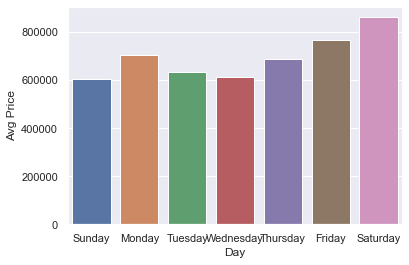

In [5]:
avg_data = {'Sunday': [0,0], 'Monday': [0,0], 'Tuesday': [0,0], 'Wednesday': [0,0], 'Thursday': [0,0], 'Friday': [0,0], 'Saturday': [0,0]}
for i, r in data.iterrows():
    day = r['ts'].day_name()
    avg_data[day][0] += r['quantity']*r['unit_price']
    avg_data[day][1] += r['quantity']

plot_data = []
for day in avg_data:
    plot_data.append([day, avg_data[day][0]/avg_data[day][1]])
plot_data = pandas.DataFrame(plot_data, columns=['Day', 'Avg Price'])
sns.barplot(x="Day", y="Avg Price", data=plot_data)

Find the average price per day on the cheapest 10% of the item's auctions

  0%|          | 0/2012 [00:00<?, ?it/s]

<AxesSubplot:xlabel='Day', ylabel='Avg Price'>

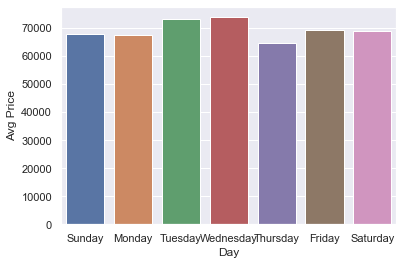

In [6]:
avg_data = {'Sunday': [0,0], 'Monday': [0,0], 'Tuesday': [0,0], 'Wednesday': [0,0], 'Thursday': [0,0], 'Friday': [0,0], 'Saturday': [0,0]}

for ts in tqdm(data.ts.unique()):
    pts = pandas.Timestamp(ts, unit='s')
    hourly_data = data[data['ts'] == ts]
    number_needed = hourly_data.quantity.sum() * .1
    prices = data.unit_price.unique()
    prices.sort()
    for p in prices:
        if number_needed <= 0:
            break
        hourly_at_price = hourly_data[hourly_data['unit_price'] == p]
        hourly_at_price_i = hourly_at_price.quantity.sum()
        if number_needed > hourly_at_price_i:
            number_needed -= hourly_at_price_i
            avg_data[pts.day_name()][0] += hourly_at_price_i * p
            avg_data[pts.day_name()][1] += hourly_at_price_i
        else:
            number_needed -= number_needed
            avg_data[pts.day_name()][0] += number_needed * p
            avg_data[pts.day_name()][1] += number_needed
            
plot_data = []
for day in avg_data:
    plot_data.append([day, avg_data[day][0]/avg_data[day][1]])
plot_data = pandas.DataFrame(plot_data, columns=['Day', 'Avg Price'])
sns.barplot(x="Day", y="Avg Price", data=plot_data)